# Artificial Neural Network Regression on the Collected Data

In this Jupyter notebook we will be applying the Artificial Neural Network Regression on the data that we have extracted (Real_Combine.csv) and try to make predictions for the AQI (PM 2.5) based on different factors :

- T	:   Average temperature (°C)
- TM:	Maximum temperature (°C)
- Tm:	Minimum temperature (°C)
- SLP:	Atmospheric pressure at sea level (hPa)
- H	:   Average relative humidity (%)
- VV:	Average visibility (Km)
- V :   Average wind speed (Km/h)
- VM:	Maximum sustained wind speed (Km/h)

## Importing the important libraries required

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout
from sklearn import metrics
from keras_tuner.tuners import RandomSearch

## Reading the Dataset

In [2]:
df = pd.read_csv('Data\Real-Data\Real_Combine.csv')

In [3]:
# Visualizing the data
df

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,14.9,21.6,8.8,1017.4,76.0,0.8,0.9,7.6,172.750000
1,14.7,21.6,10.2,1018.1,97.0,0.6,3.1,9.4,146.791667
2,15.0,16.8,13.6,1017.5,94.0,0.5,0.9,7.6,113.875000
3,9.8,17.6,6.4,1016.6,90.0,0.5,3.9,11.1,227.000000
4,10.1,14.5,7.2,1019.2,90.0,0.3,3.3,7.6,231.250000
...,...,...,...,...,...,...,...,...,...
1076,13.9,23.2,5.5,1017.2,69.0,1.0,4.1,13.0,375.791667
1077,13.0,23.1,4.6,1017.0,74.0,1.1,3.5,9.4,223.250000
1078,13.3,22.4,4.4,1016.5,72.0,1.1,5.2,9.4,248.958333
1079,15.0,21.9,6.0,1013.5,68.0,1.0,5.4,11.1,441.416667


Here we can see that we are having 1081 rows and 9 columns (features). Where T, TM, Tm, SLP, H, VV, V, VM are the independent features and PM 2.5 is the dependent feature.

In [4]:
# checking for null values in Data

df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    3
dtype: int64

Here we can see that we are having 3 null values in the Target feature that needs to handled.

c:\users\prank\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


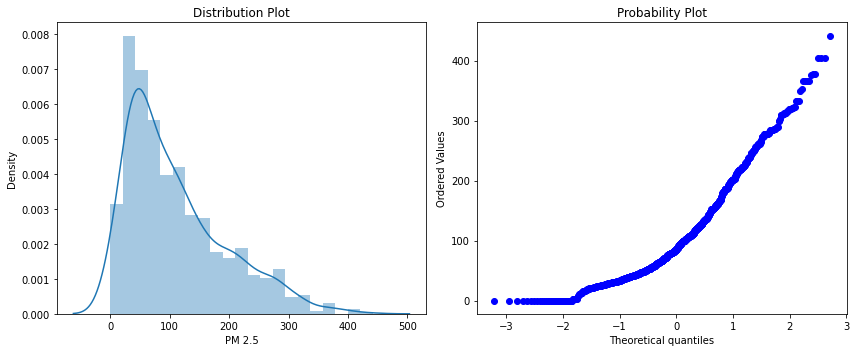

In [5]:
# observing the distribution of 'PM 2.5' target value

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.distplot(df['PM 2.5'])
plt.title('Distribution Plot')

plt.subplot(1,2,2)
stats.probplot(df['PM 2.5'], dist="norm", plot=plt)
plt.tight_layout()

It can be seen that the target variable 'PM 2.5' have right skewed value, we can handle the null values by two ways 
- dropping the records as there are only three null records
- replacing the null values with the median value

In [6]:
# replacing the null values with the median value

df['PM 2.5'].fillna(df['PM 2.5'].median(), inplace = True)

In [7]:
# checking if the null values are replaced successfully

df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

## Observing the correlations between the features

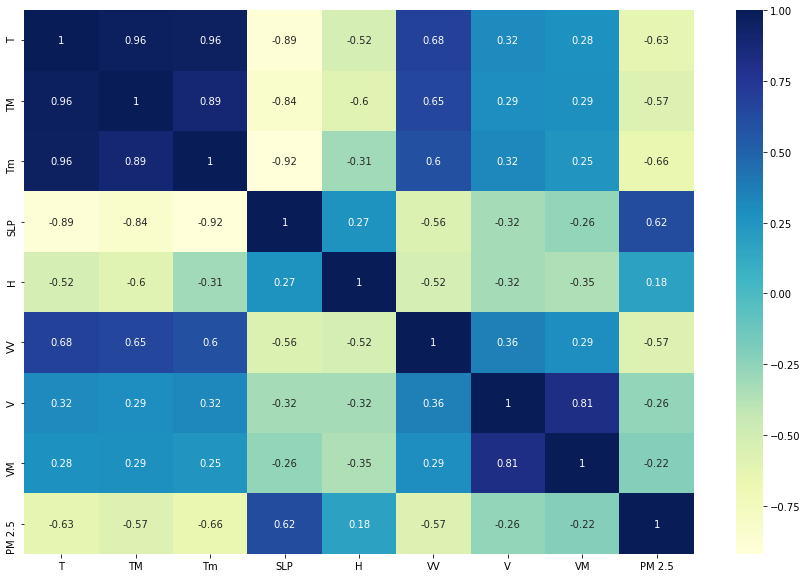

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

From the heatmap we can easily identify the correlations between the features and understand their importance in predicting the values for 'PM 2.5'.

### Dividing the data into dependent and independent features

In [9]:
# independent features
x = df.iloc[:,:-1]

# dependent features
y = df.iloc[:,-1]

In [10]:
print(x.shape,' ',y.shape)

(1081, 8)   (1081,)


### Understanding the feature importance

In [11]:
model = ExtraTreesRegressor()
model.fit(x,y)

ExtraTreesRegressor()

In [12]:
# identifying the importance of features

model.feature_importances_

array([0.18299164, 0.097935  , 0.20676971, 0.18234369, 0.07281844,
       0.15332658, 0.05308928, 0.05072566])

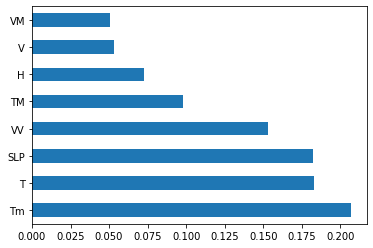

In [13]:
# visualizing the feature importance graphically

feature_importance = pd.Series(model.feature_importances_, index = x.columns)
feature_importance.nlargest(10).plot(kind = 'barh')
plt.show()

## Train Test Split

In [14]:
# splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

print(x_train.shape,' ',y_train.shape)
print(x_test.shape,' ',y_test.shape)

(864, 8)   (864,)
(217, 8)   (217,)


## Creating the ANN Regression Model

In [15]:
# creating model
ANN_model = Sequential()

# Input layer
ANN_model.add(Dense(128, kernel_initializer = 'normal', input_dim = x_train.shape[1]))

# Hidden layer
ANN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
ANN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
ANN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
              
# Output layer
ANN_model.add(Dense(1, kernel_initializer = 'normal', activation = 'linear'))
              
# compile the network 
ANN_model.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['mean_absolute_error'])
ANN_model.summary()
              
# fitting the ANN on train data
model_history = ANN_model.fit(x_train, y_train, validation_split = 0.33, batch_size = 10, epochs = 100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 166,017
Trainable params: 166,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
58/58 [==============================] - 1s 5ms/step - loss: 72.5123 - mean_absolute_error: 72.5123 - va

Epoch 44/100
58/58 [==============================] - 0s 2ms/step - loss: 43.8712 - mean_absolute_error: 43.8712 - val_loss: 43.6967 - val_mean_absolute_error: 43.6967
Epoch 45/100
58/58 [==============================] - 0s 2ms/step - loss: 48.1380 - mean_absolute_error: 48.1380 - val_loss: 44.6625 - val_mean_absolute_error: 44.6625
Epoch 46/100
58/58 [==============================] - 0s 2ms/step - loss: 45.9347 - mean_absolute_error: 45.9347 - val_loss: 45.5846 - val_mean_absolute_error: 45.5846
Epoch 47/100
58/58 [==============================] - 0s 2ms/step - loss: 44.5495 - mean_absolute_error: 44.5495 - val_loss: 44.8257 - val_mean_absolute_error: 44.8257
Epoch 48/100
58/58 [==============================] - 0s 2ms/step - loss: 45.3230 - mean_absolute_error: 45.3230 - val_loss: 44.7573 - val_mean_absolute_error: 44.7573
Epoch 49/100
58/58 [==============================] - 0s 2ms/step - loss: 44.2653 - mean_absolute_error: 44.2653 - val_loss: 46.8449 - val_mean_absolute_error: 

Epoch 93/100
58/58 [==============================] - 0s 2ms/step - loss: 43.2225 - mean_absolute_error: 43.2225 - val_loss: 43.9304 - val_mean_absolute_error: 43.9304
Epoch 94/100
58/58 [==============================] - 0s 2ms/step - loss: 43.9872 - mean_absolute_error: 43.9872 - val_loss: 48.0871 - val_mean_absolute_error: 48.0871
Epoch 95/100
58/58 [==============================] - 0s 2ms/step - loss: 46.3364 - mean_absolute_error: 46.3364 - val_loss: 48.4707 - val_mean_absolute_error: 48.4707
Epoch 96/100
58/58 [==============================] - 0s 2ms/step - loss: 45.4724 - mean_absolute_error: 45.4724 - val_loss: 43.1362 - val_mean_absolute_error: 43.1362
Epoch 97/100
58/58 [==============================] - 0s 2ms/step - loss: 42.2963 - mean_absolute_error: 42.2963 - val_loss: 42.9117 - val_mean_absolute_error: 42.9117
Epoch 98/100
58/58 [==============================] - 0s 2ms/step - loss: 43.5399 - mean_absolute_error: 43.5399 - val_loss: 43.0674 - val_mean_absolute_error: 

In [16]:
# making predictions for test data

pred = ANN_model.predict(x_test)

c:\users\prank\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

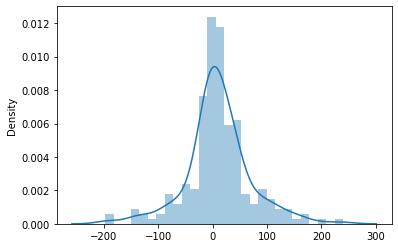

In [17]:
# observing the 'y_test - pred' graphically

sns.distplot(y_test.values.reshape(-1,1) - pred)

## Evaluation Metrics

In [18]:
# observing 'MAE', 'MSE', 'RMSE'

print('MAE : ', metrics.mean_absolute_error(y_test,pred))
print('MSE : ', metrics.mean_squared_error(y_test,pred))
print('RMSE : ', np.sqrt(metrics.mean_squared_error(y_test,pred)))

MAE :  41.19179210047568
MSE :  3679.9365716832003
RMSE :  60.662480757740205
